In [1]:
import os
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Set the working directory to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.config import Config

# Create default config
# DEFAULT_CONFIG_PATH = os.path.join(os.path.dirname(__file__), '../config/config.yaml')
Config = Config.from_yaml(os.path.join(project_root, 'config/config.yaml'))

import numpy as np
import tensorflow as tf
import strawberryfields as sf
from strawberryfields.ops import *
import pickle
import random as rd
import warnings
from datetime import datetime
import uncertainty_toolbox as uct
from itertools import product
from tqdm import tqdm

from src.dataloader import get_data, quartic_data
from src.plotting import plot_predictions, plot_training_results, plot_predictions_new, plot_eval_metrics, plot_mlp_architecture_vs_rmse, plot_data
from src.baseline import train_mlp_baseline, predict_mlp_baseline, train_polynomial_baseline, predict_polynomial_baseline
from src.uq import selective_prediction, compute_eval_metrics
from src.model import train_memristor, predict_memristor, build_circuit
from src.utils import format_metrics, format_hyperparameters
from src.logger import log_experiment_id

tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
rd.seed(42)


In [4]:
print(Config.log_file_name)
print(Config.plot_path)
print(Config.param_id)

Config.log_file_name = "logs_20241206_114647.txt"
Config.plot_path = "reports/baseline_20241206_114647/plots"
Config.param_id = "hp_s5_lr0.05_md5_cd4"

X_train, y_train, X_test, y_test, _ = get_data(n_data=Config.data.n_data, 
                                                sigma_noise_1=Config.data.sigma_noise_1, 
                                                datafunction=quartic_data
                                                )


logs_20241206_114647.txt
reports/baseline_20241206_114647/plots
hp_s5_lr0.05_md5_cd4


In [ ]:
# Create directory called experiment_CONFIG.LOG_NAME in reports/logs
date = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"reports/baseline_{date}/logs", exist_ok=False)
os.makedirs(f"reports/baseline_{date}/plots", exist_ok=False)

Config.log_file_name = f"reports/baseline_{date}/log.txt"
Config.plot_path = f"reports/baseline_{date}/plots/"
Config.param_id = f"hp_s{Config.training.steps}_lr{Config.training.learning_rate}_md{Config.training.memory_depth}_cd{Config.training.cutoff_dim}"    

# Log experiment id
log_experiment_id(Config.log_file_name, Config.param_id, "Selective Prediction Sample")



X_train, y_train, X_test, y_test, _ = get_data(n_data=Config.data.n_data, 
                                                sigma_noise_1=Config.data.sigma_noise_1, 
                                                datafunction=quartic_data
                                                )

# Train model
res_mem, phase1, phase3, memristor_weight = train_memristor(X_train, 
                                                            y_train, 
                                                            memory_depth=6, 
                                                            training_steps=70,
                                                            learning_rate=0.1,
                                                            cutoff_dim=4,
                                                            log_filepath=Config.log_file_name,
                                                            log_path=f"reports/baseline_{date}/",
                                                            param_id=Config.param_id
                                                            )

# Predict model
predictions, targets, predictive_uncertainty, all_predictions = predict_memristor(X_test, 
                                                                y_test, 
                                                                memory_depth=6, 
                                                                phase1=phase1, 
                                                                phase3=phase3, 
                                                                memristor_weight=memristor_weight,
                                                                stochastic=True, 
                                                                var=0.1, 
                                                                samples=300,
                                                                cutoff_dim=4,
                                                                log_filepath=Config.log_file_name,
                                                                log_path=f"reports/baseline_{date}/",
                                                                param_id=Config.param_id
                                                                ) 

Prediction Samples:  72%|███████▏  | 215/300 [37:59<14:44, 10.40s/sample]

: 

In [ ]:
all_predictions[0]

In [6]:
trained_params = {
    'res_mem': res_mem,
    'phase1': phase1.numpy(),
    'phase3': phase3.numpy(),
    'memristor_weight': memristor_weight.numpy()
}
log_path = f"reports/baseline_{date}/"
# Define the filename
pickle_filename = f"{log_path}trained_params_{Config.param_id}.pkl"

# Save the data to a pickle file
with open(pickle_filename, 'wb') as f:
    pickle.dump(trained_params, f)

In [9]:
with open("reports/baseline_20241206_112453/trained_params_hp_s5_lr0.05_md5_cd4", 'rb') as f:
    trained_params = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'reports/baseline_20241206_112453/trained_params_hp_s5_lr0.05_md5_cd4'

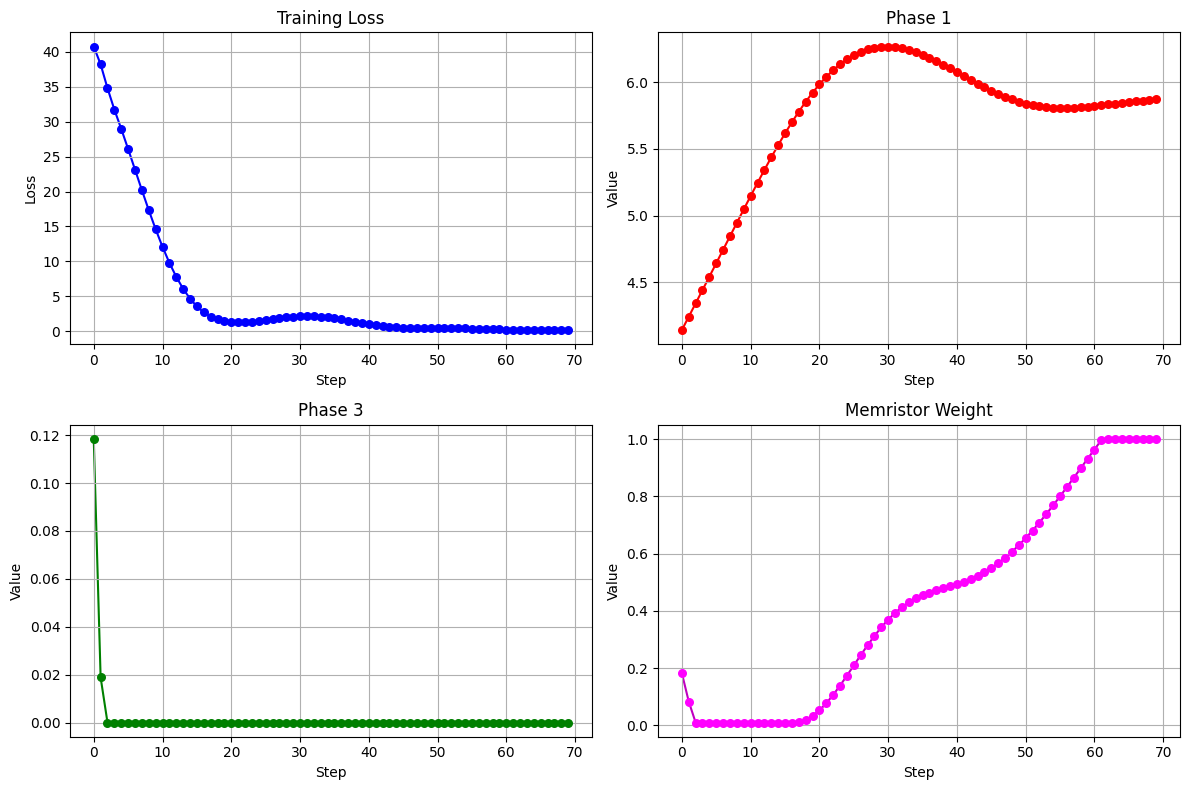

In [7]:
plot_training_results(res_mem)

In [ ]:
# Predict model
predictions, targets, predictive_uncertainty, all_predictions = predict_memristor(X_test, 
                                                                y_test, 
                                                                memory_depth=6, 
                                                                phase1=phase1, 
                                                                phase3=phase3, 
                                                                memristor_weight=memristor_weight,
                                                                stochastic=True, 
                                                                var=0.1, 
                                                                samples=300,
                                                                cutoff_dim=4,
                                                                log_filepath=Config.log_file_name,
                                                                log_path=f"reports/baseline_{date}/",
                                                                param_id=Config.param_id
                                                                )

Prediction Samples:   0%|          | 1/300 [00:11<55:16, 11.09s/sample]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107898190>>
Traceback (most recent call last):
  File "/Users/anani/Code/uq-qnn/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Prediction Samples:   1%|          | 2/300 [00:21<53:33, 10.78s/sample]

In [ ]:
plot_predictions_new(X_test, y_test, predictions, predictive_uncertainty)
